In [1]:
# import everything you need
import numpy as np
import scipy as sp
import pandas as pd
# activate matplotlib inline magics
%matplotlib inline 
# import matplotlib.pyplot as plt
# import matplotlib.image as mpl_img
import seaborn as sns
# specific fo statistics
import pingouin as pg
# for the interaction with r
# activate r inline magics
%load_ext rpy2.ipython

Define neccesary parameters

In [2]:
# "Fixed file from Jay still containt wrong/missing values for 46, switched to the most recent file Jay sent me (gmail)"
data_file = "FED_fMRI_fullcodesfixed_final_II.xls"
covariate_file = "FED_Subject_Covariates.xls"

Create the neccessary factors and sort all variables appropriately

In [ ]:
# taken from Koster et al (2005)
# RTs < 200 ms and RTs > 750 ms were considered outliers, indicating anticipatory responding and delayed responding, respectively.
# Also, RTs deviating more than 3 SDs from the individual mean RT were excluded.
# -> See what conditions are met in the final data file and adapt if necessary!!!

In [3]:
# extract - data from list in .xls file(s). Outliers and all known errors have already been corrected (see recent "ALLCODESFIXED")
# read relevant content
anova = pd.read_excel(data_file, sheet_name="Final",
                      usecols = ['Subject', 'Condition', 'RT', 'Accuracy'])
covariates = pd.read_excel(covariate_file, sheet_name="analysis",
                           usecols = ['FED_ID', 'BDI_22_Score', 'Gender', 'Age', 'Race'])

# remove all inaccurate (val = 2) trials
anova = anova.loc[anova["Accuracy"] == 1]
# and drop the column
anova = anova.drop('Accuracy', axis = 1)

# remove  200 > RT data > 750
anova = anova.loc[(anova["RT"] >= 200) & (anova["RT"] <= 750)]

# define list of subject numbers
fed_nums = [num for num in range(7, 69)]
# remove first six subjects
anova = anova[(anova.Subject.isin(fed_nums))]
covariates = covariates[(covariates.FED_ID.isin(fed_nums))]

# create variables cue_valence and trial_validity after Condition and assign values according to trial codings (neg, pos, neu) (valid, invalid)
neg, pos, neu = [1, 4, 7, 10], [2, 5, 8, 11], [3, 6, 9, 12]
valid, invalid = [val for val in range(7, 13)], [val for val in range(1, 7)]
# create list of group, valence and validity numerical indices
group_cats, valence_cats, validity_cats = ["dep", "con"], ["neg", "pos", "neu"], ["valid", "invalid"]
# copy Condition list and replace
anova['Cue_Valence'] = anova['Condition']
for valence, name in zip([neg, pos, neu], valence_cats):
    anova.loc[anova['Condition'].isin(valence), 'Cue_Valence'] = name

anova['Trial_Validity'] = anova['Condition']
for validity, name in zip([valid, invalid], validity_cats):
    anova.loc[anova['Condition'].isin(validity), 'Trial_Validity'] = name

# create variable DStatus after Subject and replace each subject value with the corresponding group identity
# separate covariate FED_IDs by BDI22
mdd = covariates.FED_ID[covariates['BDI_22_Score'] == 1]
control = covariates.FED_ID[covariates['BDI_22_Score'] == 0]
# copy Subject list and replace
anova['DStatus'] = anova['Subject']
anova.loc[anova['Subject'].isin(mdd), 'DStatus'] = group_cats[0]
anova.loc[anova['Subject'].isin(control), 'DStatus'] = group_cats[1]

# sort values by DStatus, valence and validity (by factor, starting with largest increment)
anova.sort_values(['DStatus', 'Trial_Validity', 'Cue_Valence'], inplace = True)

In [4]:
pd.set_option('display.max_rows', None)
print(anova)

           RT  Subject  Condition Cue_Valence Trial_Validity DStatus
1071   302.35        7          1         neg        invalid     con
1072   256.12        7          1         neg        invalid     con
1073   285.54        7          1         neg        invalid     con
1074   303.62        7          1         neg        invalid     con
1075   266.26        7          1         neg        invalid     con
1076   294.58        7          1         neg        invalid     con
1077   332.54        7          1         neg        invalid     con
1079   281.30        7          1         neg        invalid     con
1090   577.72        7          1         neg        invalid     con
1091   296.54        7          1         neg        invalid     con
1092   360.85        7          1         neg        invalid     con
1093   321.91        7          1         neg        invalid     con
1094   321.38        7          1         neg        invalid     con
1126   291.56        7          4 

In [5]:
# ANOVA above uses all raw RTs per subject across each UV level.
# Create RT means for smallest increment (validity) t get single values per subject (ANOVA error variance dofs)
# copy data to avoid accidents
anova_submeans = anova.copy().drop('Condition', axis=1)

# list RT by subject, valence and validity, respectively
for sub in anova_submeans['Subject'].unique():
    for valence in anova_submeans['Cue_Valence'].unique():
        for valid in anova_submeans['Trial_Validity'].unique():
            # fix the mean at the beginning of each condition to avoid bias towards the first subject in case this assigns sequentially
            sub_mean = anova_submeans["RT"][(anova_submeans['Subject'] == sub)
                                          & (anova_submeans['Cue_Valence'] == valence)
                                          & (anova_submeans['Trial_Validity'] == valid)].mean()
            # locate and replace the individual RT values with the mean by subject, valence and validity
            anova_submeans.loc[(anova_submeans['Subject'] == sub) & (anova_submeans['Cue_Valence'] == valence)
                                                                  & (anova_submeans['Trial_Validity'] == valid), 'RT'] = sub_mean

# drop duplicate lines from the dataframe
anova_submeans = anova_submeans.drop_duplicates()

In [6]:
pd.set_option('display.max_rows', None)
print(anova_submeans)

               RT  Subject Cue_Valence Trial_Validity DStatus
1071   320.278571        7         neg        invalid     con
1251   324.400000        8         neg        invalid     con
1431   302.652500        9         neg        invalid     con
1608   321.222500       10         neg        invalid     con
1966   317.846207       12         neg        invalid     con
2145   373.101923       13         neg        invalid     con
2492   416.560000       15         neg        invalid     con
2671   279.850357       16         neg        invalid     con
2842   265.769310       17         neg        invalid     con
3198   327.416207       19         neg        invalid     con
3377   267.342963       20         neg        invalid     con
3552   377.528276       21         neg        invalid     con
3731   297.739643       22         neg        invalid     con
3909   294.147931       23         neg        invalid     con
4085   306.373571       24         neg        invalid     con
4262   3

Build three-way ANOVA design and calculate the F-test using R

In [13]:
# r libraries:

# library(tidyverse)
# library(ggpubr)
# library(ggpmisc)
# library(rstatix)
# library(afex)
# library(emmeans)
# library(xtable)

# packages in environment at /opt/miniconda-latest/envs/neuro:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
_r-mutex                  1.0.1               anacondar_1    conda-forge
alsa-lib                  1.2.3                h516909a_0    conda-forge
annexremote               1.5.0                    pypi_0    pypi
anyio                     3.1.0            py37h89c1867_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               20.1.0           py37h5e8e339_2    conda-forge
astor                     0.8.1                    pypi_0    pypi
astroid                   2.5.7            py37h89c1867_0    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
autope

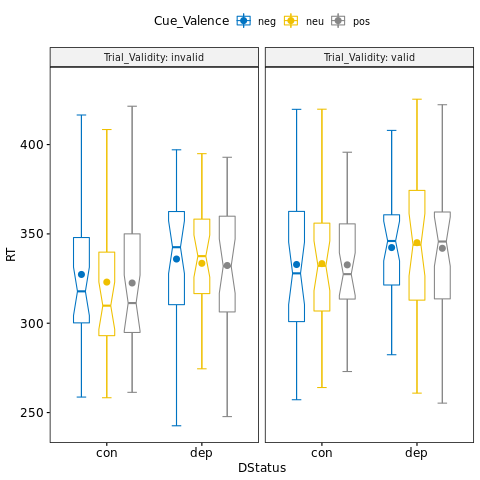

In [8]:
%%R -i anova_submeans

# load r libraries
library(ggpubr)

# plot categorical data to get an overview
# create the plot
anova_boxplot <- ggboxplot(anova_submeans, x = "DStatus", y = "RT",
                          color = "Cue_Valence", facet.by = "Trial_Validity",
                          notch = TRUE, add = "mean", error.plot = "errorbar",
                          bxp.errorbar = TRUE, bxp.errorbar.width = 0.3,
                          outlier.shape = NA, palette = "jco",
                          width = 0.5, short.panel.labs = FALSE)

#str(anova_boxplot$layers)
# plot it
anova_boxplot

# # save plot to png
# ggsave("boxplot_322_anova.png", plot = anova_boxplot)

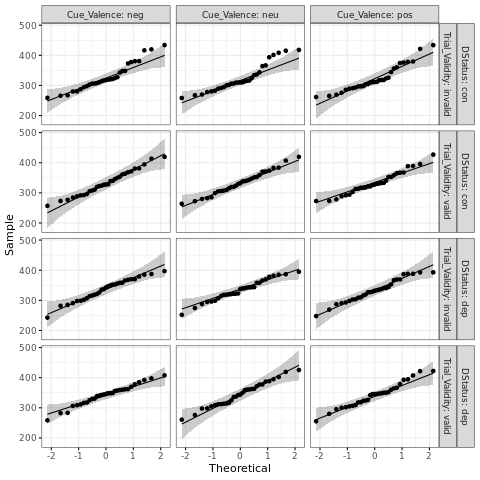

In [10]:
%%R -i anova_submeans

# load r libraries
library(ggpubr)

# check whether variances are equal using QQPlots
qq_plot_332_anova <- ggqqplot(anova_submeans, "RT", ggtheme = theme_bw()) +
                     facet_grid(DStatus + Trial_Validity ~ Cue_Valence,
                     labeller = "label_both")

# plot it
qq_plot_332_anova

# # save plot to png
# ggsave("qqplot_322_anova.png", plot = qq_plot_332_anova)

In [11]:
%%R -i anova_submeans

# load r libraries
library(rstatix)
library(xtable)

# check whether variances are equal using Shapiro-Wilk’s test
rm_322_shapiro <- anova_submeans %>% group_by(DStatus, Trial_Validity, Cue_Valence) %>% shapiro_test(RT)

# check whether variances are homogenous using Levene tests
rm_322_levene <- anova_submeans %>% group_by(Trial_Validity, Cue_Valence) %>% levene_test(RT ~ DStatus)

# print them
# print(rm_322_shapiro)
# print(rm_322_levene)

# transfer tables to latex
tex_shap = xtable(rm_322_shapiro, digits = 3)
tex_leve = xtable(rm_322_levene, digits = 3)
print(tex_shap)
print(tex_leve)

R[write to console]: 
Attaching package: ‘rstatix’


R[write to console]: The following object is masked from ‘package:stats’:

    filter




% latex table generated in R 4.0.5 by xtable 1.8-4 package
% Wed Jun 23 09:53:54 2021
\begin{table}[ht]
\centering
\begin{tabular}{rllllrr}
  \hline
 & Cue\_Valence & Trial\_Validity & DStatus & variable & statistic & p \\ 
  \hline
1 & neg & invalid & con & RT & 0.930 & 0.045 \\ 
  2 & neu & invalid & con & RT & 0.897 & 0.006 \\ 
  3 & pos & invalid & con & RT & 0.916 & 0.018 \\ 
  4 & neg & valid & con & RT & 0.981 & 0.852 \\ 
  5 & neu & valid & con & RT & 0.985 & 0.924 \\ 
  6 & pos & valid & con & RT & 0.966 & 0.420 \\ 
  7 & neg & invalid & dep & RT & 0.972 & 0.577 \\ 
  8 & neu & invalid & dep & RT & 0.978 & 0.751 \\ 
  9 & pos & invalid & dep & RT & 0.969 & 0.487 \\ 
  10 & neg & valid & dep & RT & 0.980 & 0.818 \\ 
  11 & neu & valid & dep & RT & 0.983 & 0.889 \\ 
  12 & pos & valid & dep & RT & 0.976 & 0.681 \\ 
   \hline
\end{tabular}
\end{table}
% latex table generated in R 4.0.5 by xtable 1.8-4 package
% Wed Jun 23 09:53:54 2021
\begin{table}[ht]
\centering
\begin{tabular}

In [12]:
%%R -i anova_submeans

# load r libraries
library(afex)
# library(emmeans)
library(xtable)
# caculate the 3x2x2 ANOVA (type III SS)
rm_322_anova <- aov_ez("Subject", "RT", anova_submeans,
                       between = "DStatus", within = c("Cue_Valence", "Trial_Validity"), type = "III",
                       anova_table = c(es = "pes"), return = "afex_aov", print.formula = FALSE)

# get nice ANOVA table
nice_322 <- nice(rm_322_anova)
# get full summary table
# sum_322 <- summary(rm_322_anova)

# build summary grid for the anova data
# ref <- emmeans(rm_322_anova, specs = c("Cue_Valence", "Trial_Validity", "DStatus"))

# print the results
# print(nice_322)
# print(sum_322)
# print(ref)

# transfer tables to latex
tex_tab = xtable(nice_322, digits = 3)
print(tex_tab)

R[write to console]: Loading required package: lme4

R[write to console]: Loading required package: Matrix

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

R[write to console]: ************
Welcome to afex. For support visit: http://afex.singmann.science/

R[write to console]: - Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

R[write to console]: 
Attaching package:

% latex table generated in R 4.0.5 by xtable 1.8-4 package
% Wed Jun 23 09:54:03 2021
\begin{table}[ht]
\centering
\begin{tabular}{rllllll}
  \hline
 & Effect & df & MSE & F & pes & p.value \\ 
  \hline
1 & DStatus & 1, 60 & 8530.54 & 1.07 & .017 & .305 \\ 
  2 & Cue\_Valence & 1.85, 111.28 & 142.22 & 1.21 & .020 & .300 \\ 
  3 & DStatus:Cue\_Valence & 1.85, 111.28 & 142.22 & 0.27 & .005 & .744 \\ 
  4 & Trial\_Validity & 1, 60 & 545.69 & 13.62 *** & .185 & $<$.001 \\ 
  5 & DStatus:Trial\_Validity & 1, 60 & 545.69 & 0.01 & $<$.001 & .916 \\ 
  6 & Cue\_Valence:Trial\_Validity & 1.93, 115.56 & 82.25 & 2.66 + & .042 & .076 \\ 
  7 & DStatus:Cue\_Valence:Trial\_Validity & 1.93, 115.56 & 82.25 & 0.08 & .001 & .916 \\ 
   \hline
\end{tabular}
\end{table}


In [13]:
%%R -i anova_submeans -i valence_cats -i validity_cats

# load r libraries
library(afex)
library(xtable)

# examine the reason for non-significant 3x2x2 interactions
# calculate 3 2x2 ANOVAs on each level of valence (type III SS)
rmv1_22_anova <- list()
for (val in valence_cats) {
    level <- aov_ez("Subject", "RT", filter(anova_submeans, Cue_Valence == val),
                    between = "DStatus", within = "Trial_Validity", type = "III",
                    anova_table = c(es = "pes"), return = "nice", print.formula = FALSE)
    rmv1_22_anova <- append(rmv1_22_anova, c(val, list(level)))
    }

# calculate 2 3x2 ANOVAs on each level of validity (type III SS)
rmv2_22_anova <- list()
for (val in validity_cats) {
    level <- aov_ez("Subject", "RT", filter(anova_submeans, Trial_Validity == val),
                    between = "DStatus", within = "Cue_Valence", type = "III",
                    anova_table = c(es = "pes"), return = "nice", print.formula = FALSE)
    rmv2_22_anova <- append(rmv2_22_anova, c(val, list(level)))
    }

# collect val identifier and NAOVA table into list
rmv1_tables <- list(list(rmv1_22_anova[1], rmv1_22_anova[2]),
                    list(rmv1_22_anova[3], rmv1_22_anova[4]),
                    list(rmv1_22_anova[5], rmv1_22_anova[6]))

rmv2_tables <- list(list(rmv2_22_anova[1], rmv2_22_anova[2]),
                    list(rmv2_22_anova[3], rmv2_22_anova[4]))

# check list indexing works (Python rules ... this is annoying)
# print(rmv1_tables[[1]][c(1:2)])
# print(rmv2_tables[[1]][c(1:2)])

# transfer tables to latex
for (val_tab in rmv1_tables) {
    tex_tab <- xtableList(val_tab[[2]], digits = 3)
    print(val_tab[[1]])
    print(tex_tab)
    cat("\n")
    }

for (val_tab in rmv2_tables) {
    tex_tab <- xtableList(val_tab[[2]], digits = 3)
    print(val_tab[[1]])
    print(tex_tab)
    cat("\n")
    }

R[write to console]: Converting to factor: DStatus

R[write to console]: Contrasts set to contr.sum for the following variables: DStatus

R[write to console]: Converting to factor: DStatus

R[write to console]: Contrasts set to contr.sum for the following variables: DStatus

R[write to console]: Converting to factor: DStatus

R[write to console]: Contrasts set to contr.sum for the following variables: DStatus

R[write to console]: Converting to factor: DStatus

R[write to console]: Contrasts set to contr.sum for the following variables: DStatus

R[write to console]: Converting to factor: DStatus

R[write to console]: Contrasts set to contr.sum for the following variables: DStatus



[[1]]
[1] "neg"

% latex table generated in R 4.0.5 by xtable 1.8-4 package
% Wed Jun 23 09:54:09 2021
\begin{table}[ht]
\centering
\begin{tabular}{rllllll}
  \hline
 & Effect & df & MSE & F & pes & p.value \\ 
  \hline
1 & DStatus & 1, 60 & 2919.68 & 0.87 & .014 & .354 \\ 
  2 & Trial\_Validity & 1, 60 & 219.38 & 5.07 * & .078 & .028 \\ 
  3 & DStatus:Trial\_Validity & 1, 60 & 219.38 & 0.03 & $<$.001 & .874 \\ 
   \hline
\multicolumn{7}{l}{}\\
\end{tabular}
\end{table}

[[1]]
[1] "pos"

% latex table generated in R 4.0.5 by xtable 1.8-4 package
% Wed Jun 23 09:54:09 2021
\begin{table}[ht]
\centering
\begin{tabular}{rllllll}
  \hline
 & Effect & df & MSE & F & pes & p.value \\ 
  \hline
1 & DStatus & 1, 60 & 2897.41 & 0.97 & .016 & .328 \\ 
  2 & Trial\_Validity & 1, 60 & 250.24 & 12.12 *** & .168 & $<$.001 \\ 
  3 & DStatus:Trial\_Validity & 1, 60 & 250.24 & 0.01 & $<$.001 & .928 \\ 
   \hline
\multicolumn{7}{l}{}\\
\end{tabular}
\end{table}

[[1]]
[1] "neu"

% latex table generated i

Calculate Cue Validity (CV), Attentional Engagement (AE), and Difficulty in Attentional Disengagement (DAD) based on subject RT means for each condition

In [ ]:
# JAY's ORIGINAL QUOTE FROM 5 YEARS AGO:
# What I did was to run the CV equation on the individual subject means instead of the overall mean by condition. In MATLAB, it looked like this for positive CV:

# datastruct.CV_POS = (datastruct.RT_POS_INVAL - datastruct.RT_POS_VALID);
# CV_Positive = mean(datastruct.CV_POS(1,:));

# So datastruct.CV_POS has the cue validity score for positive stimuli for each subject. Then I take the mean with the next line,
# and those are the CV scores I sent you guys last night.

In [13]:
# create RT means for smallest increment (validity)
# copy data to avoid accidents
eect_ttest = anova_submeans.copy()

# list RT by subject, valence and validity, respectively
rts = {}
for sub in eect_ttest['Subject'].unique():
    for valence in eect_ttest['Cue_Valence'].unique():
        for valid in eect_ttest['Trial_Validity'].unique():
            rts[f"{sub}_{valence}_{valid}"] = eect_ttest.loc[(eect_ttest['Subject'] == sub)
                                                           & (eect_ttest['Cue_Valence'] == valence) 
                                                           & (eect_ttest['Trial_Validity'] == valid), 'RT'].tolist()

In [14]:
# calculate CV for each valence per subject
cv = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    for val in valence_cats:
        # create list for validity-referenced combos
        validity = []
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # fix the subject ID
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1]) == val:
                # collect validities
                validity.append(combo)
        #print(validity)
        # calculate the inv-v difference by valence
        cv[f"{sub}_{val}"] = [inv - v for inv, v in zip(rts[validity[0]], rts[validity[1]])]

# transfer to pd.dataframe
cv = (pd.DataFrame.from_dict(cv, orient='index', columns=['CV']).rename_axis('FEDbyvalence').reset_index())

In [15]:
# calculate AE for each valence per subject
ae = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set valid neutral reference
            reference = f"{sub}_{ref}_valid"
            # fix the subject ID, and validity to valid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "valid":
                #print(reference, combo)
                # calculate the vneu-vemo difference by valence
                ae[f"{sub}_{val}"] = [vneu - vemo for vneu, vemo in zip(rts[reference], rts[combo])]

# transfer to pd.dataframe
ae = (pd.DataFrame.from_dict(ae, orient='index', columns=['AE']).rename_axis('FEDbyvalence').reset_index())

In [16]:
# calculate DAD for each valence per subject
dad = {}
# start at subject index level
for sub in fed_nums:
    # iterate across valences
    ref = valence_cats[-1]  # neutral is always reference
    for val in valence_cats[:-1]:
        # go through combinations of conditions by subject
        for combo in rts.keys():
            # set invalid neutral reference
            reference = f"{sub}_{ref}_invalid"
            # fix the subject ID, and validity to invalid
            if (int(combo.split('_', 1)[0]) == sub and combo.split('_', 2)[1] == val and combo.rsplit('_', 1)[1]) == "invalid":
                #print(combo, reference)
                # calculate the invemo-invneu difference by valence
                dad[f"{sub}_{val}"] = [invemo - invneu for invemo, invneu in zip(rts[combo], rts[reference])]

# transfer to pd.dataframe
dad = (pd.DataFrame.from_dict(dad, orient='index', columns=['DAD']).rename_axis('FEDbyvalence').reset_index())

In [17]:
# add group column to each variable's dataframe
for frame in [cv, ae, dad]:
    # copy Subject, Condition lists and transform to integers
    frame['FED'] = frame['FEDbyvalence'].apply(lambda x: x.split('_', 1)[0])
    frame['Valence'] = frame['FEDbyvalence'].apply(lambda x: x.split('_', 1)[1])
    # copy FED again to obtain DStatus list
    frame['DStatus'] = frame['FED']
    # check and change by group
    frame.loc[frame['FED'].astype(int).isin(mdd), 'DStatus'] = "dep"
    frame.loc[frame['FED'].astype(int).isin(control), 'DStatus'] = "con"
    # finally, sort the dataframe by DStatus and FED
    frame.sort_values(['DStatus', 'Valence', 'FED'], inplace = True)
    # drop FEDbyvalence
    frame.drop(columns='FEDbyvalence', inplace=True)

Inspect and make sure that all variables look OK

In [18]:
pd.set_option('display.max_rows', None)
cv

,CV,FED,Valence,DStatus
9,1.201466,10,neg,con
15,12.320000,12,neg,con
18,4.846506,13,neg,con
24,22.150345,15,neg,con
27,-12.076310,16,neg,con
30,-11.014828,17,neg,con
36,-18.411724,19,neg,con
39,-5.985926,20,neg,con
42,-3.871379,21,neg,con
45,-26.141392,22,neg,con


In [19]:
ae

,AE,FED,Valence,DStatus
6,12.122632,10,neg,con
10,0.639310,12,neg,con
12,-15.326528,13,neg,con
16,-11.500322,15,neg,con
18,7.298690,16,neg,con
20,2.948966,17,neg,con
24,25.044402,19,neg,con
26,12.102146,20,neg,con
28,2.460678,21,neg,con
30,-4.457368,22,neg,con


In [20]:
dad

,DAD,FED,Valence,DStatus
6,7.838167,10,neg,con
10,12.129874,12,neg,con
12,6.503034,13,neg,con
16,-1.122333,15,neg,con
18,-2.861786,16,neg,con
20,-3.828276,17,neg,con
24,-6.575172,19,neg,con
26,0.047963,20,neg,con
28,-15.846057,21,neg,con
30,6.314815,22,neg,con


Calculate two-sided t-tests (un)like Koster (2005)

In [21]:
# calculate cauchy scaling factor of Koster et al. (2005)
# - original: https://doi.org/10.3758/PBR.16.2.225; recent implementation: https://doi.org/10.1080/00031305.2018.1562983

# transfer t_vals to cohen's d for basing on propability density function
smallest_t = 2.15
largest_t = 2.72
small_cohen = pg.compute_effsize_from_t(smallest_t, nx=20, ny=20, eftype='cohen')
large_cohen = pg.compute_effsize_from_t(largest_t, N=15, eftype='cohen')
# spectrum based on Exp1 & Exp2 results
# cohen's ds are between 0 and 1.4, round up
value_halfwidth = 2
# set scaling factor required for estimated 80% probability that the true effect sizes lie within the spectrum (+2 - -2)
cauchy_r = 0.707
# control the probability
effect_prob_est = sp.stats.cauchy.cdf(value_halfwidth, 0, cauchy_r) - sp.stats.cauchy.cdf(-value_halfwidth, 0, cauchy_r)

In [22]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for CV
# neg
cvneg_mdd = cv['CV'][(cv['Valence'] == "neg") & (cv['DStatus'] == "dep")].tolist()
cvneg_con = cv['CV'][(cv['Valence'] == "neg") & (cv['DStatus'] == "con")].tolist()
# pos
cvpos_mdd = cv['CV'][(cv['Valence'] == "pos") & (cv['DStatus'] == "dep")].tolist()
cvpos_con = cv['CV'][(cv['Valence'] == "pos") & (cv['DStatus'] == "con")].tolist()
# neu
cvneu_mdd = cv['CV'][(cv['Valence'] == "neu") & (cv['DStatus'] == "dep")].tolist()
cvneu_con = cv['CV'][(cv['Valence'] == "neu") & (cv['DStatus'] == "con")].tolist()
# put all into tupled list
cv_testbtw = [(cvneg_mdd, cvneg_con), (cvpos_mdd, cvpos_con), (cvneu_mdd, cvneu_con)]
cv_testwithin = [[group[0] for group in cv_testbtw], [group[1] for group in cv_testbtw]]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_cv_all = []
# first compare valences between groups with a 2-sample t-test
for valence in cv_testbtw:
    ttests_cv = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_cv.insert(0, "ConditionID", f"cv_btw_{valence_cats[cv_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_cv.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_cv_all.append(ttests_cv)

# Now look at the valences within groups with a paired t-test
for group in cv_testwithin:
    # compare neg and pos against neu
    for valence in [0, 1]:
        ttests_cv = pg.ttest(group[valence], group[2], paired=True, tail='two-sided', r=cauchy_r, confidence=0.95)
        # add condition and group ID (0 means control^^)
        ttests_cv.insert(0, "ConditionID", f"cv_within_{group_cats[cv_testwithin.index(group)]}_{valence_cats[[0, 1].index(valence)]}")
        # add (partial) eta-squared estimate to the dataframe
        ttests_cv.insert(7, "eta-squared", pg.compute_effsize(group[valence], group[2], paired=True, eftype='eta-square'))
        # put the finish dataframe into list
        ttests_cv_all.append(ttests_cv)

# concat list to dataframe
ttests_cv_all = pd.concat(ttests_cv_all)

In [23]:
# test whether or not all t-test RT lists have the same length
for group in cv_testwithin:
    print(f"Negative CV {len(group[0])}; Positive CV {len(group[1])}; Neutral CV {len(group[2])}")

Negative CV 31; Positive CV 31; Neutral CV 31
Negative CV 31; Positive CV 31; Neutral CV 31


In [24]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for AE
# neg
aeneg_mdd = ae['AE'][(ae['Valence'] == "neg") & (ae['DStatus'] == "dep")].tolist()
aeneg_con = ae['AE'][(ae['Valence'] == "neg") & (ae['DStatus'] == "con")].tolist()
# pos
aepos_mdd = ae['AE'][(ae['Valence'] == "pos") & (ae['DStatus'] == "dep")].tolist()
aepos_con = ae['AE'][(ae['Valence'] == "pos") & (ae['DStatus'] == "con")].tolist()
# put all into tupled list (no within comparisons here)
ae_testbtw = [(aeneg_mdd, aeneg_con), (aepos_mdd, aepos_con)]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_ae_all = []
# first compare valences between groups with a 2-sample t-test
for valence in ae_testbtw:
    ttests_ae = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_ae.insert(0, "ConditionID", f"ae_btw_{valence_cats[ae_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_ae.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_ae_all.append(ttests_ae)

# concat list to dataframe
ttests_ae_all = pd.concat(ttests_ae_all)

In [25]:
# run a two-sided t-test with appropriate p-level threshold (unlike Koster ...)
# for DAD
# neg
dadneg_mdd = dad['DAD'][(dad['Valence'] == "neg") & (dad['DStatus'] == "dep")].tolist()
dadneg_con = dad['DAD'][(dad['Valence'] == "neg") & (dad['DStatus'] == "con")].tolist()
# pos
dadpos_mdd = dad['DAD'][(dad['Valence'] == "pos") & (dad['DStatus'] == "dep")].tolist()
dadpos_con = dad['DAD'][(dad['Valence'] == "pos") & (dad['DStatus'] == "con")].tolist()
# put all into tupled list (no within comparisons here)
dad_testbtw = [(dadneg_mdd, dadneg_con), (dadpos_mdd, dadpos_con)]

# test all valences separately between and within group
# build empty list to hold all tests
ttests_dad_all = []
# first compare valences between groups with a 2-sample t-test
for valence in dad_testbtw:
    ttests_dad = pg.ttest(valence[0], valence[1], paired=False, tail='two-sided', r=cauchy_r, confidence=0.95)
    # add condition ID
    ttests_dad.insert(0, "ConditionID", f"dad_btw_{valence_cats[dad_testbtw.index(valence)]}")
    # add (partial) eta-squared estimate to the dataframe
    ttests_dad.insert(7, "eta-squared", pg.compute_effsize(valence[0], valence[1], paired=False, eftype='eta-square'))
    # put the finish dataframe into list
    ttests_dad_all.append(ttests_dad)

# concat list to dataframe
ttests_dad_all = pd.concat(ttests_dad_all)

Plot t-test results

In [26]:
# view respective ttest dicts to make sure everything looks as it should
ttests_cv_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,cv_btw_neg,-0.159356,60,two-sided,0.873924,"[-11.49, 9.79]",0.040476,0.000409,0.262,0.052822
T-test,cv_btw_pos,0.090614,60,two-sided,0.928101,"[-10.85, 11.88]",0.023016,0.000132,0.26,0.050911
T-test,cv_btw_neu,-0.220119,60,two-sided,0.826526,"[-12.21, 9.79]",0.055910,0.000781,0.264,0.055392
T-test,cv_within_dep_neg,1.557682,30,two-sided,0.129797,"[-1.6, 11.85]",0.234799,0.013595,0.568,0.244373
T-test,cv_within_dep_pos,0.736282,30,two-sided,0.467278,"[-3.38, 7.2]",0.087939,0.001930,0.246,0.076127
T-test,cv_within_con_neg,1.468960,30,two-sided,0.152253,"[-1.86, 11.39]",0.229729,0.013022,0.505,0.235954
T-test,cv_within_con_pos,0.057506,30,two-sided,0.954523,"[-6.24, 6.61]",0.008095,0.000016,0.192,0.050218


In [27]:
ttests_ae_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,ae_btw_neg,0.526888,60,two-sided,0.600214,"[-6.27, 10.75]",0.133830,0.004458,0.291,0.081324
T-test,ae_btw_pos,0.836960,60,two-sided,0.405936,"[-3.41, 8.32]",0.212588,0.011172,0.348,0.130595


In [28]:
ttests_dad_all

,ConditionID,T,dof,tail,p-val,CI95%,cohen-d,eta-squared,BF10,power
T-test,dad_btw_neg,-0.596261,60,two-sided,0.553244,"[-8.18, 4.42]",0.151450,0.005702,0.301,0.090283
T-test,dad_btw_pos,-0.206835,60,two-sided,0.836839,"[-7.78, 6.32]",0.052536,0.000690,0.264,0.054760


In [29]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(ttests_cv_all, tablefmt="latex")
pg.print_table(ttests_ae_all, tablefmt="latex")
pg.print_table(ttests_dad_all, tablefmt="latex")

\begin{tabular}{lrrlrlrrrr}
\hline
 ConditionID       &      T &   dof & tail      &   p-val & CI95\%           &   cohen-d &   eta-squared &   BF10 &   power \\
\hline
 cv\_btw\_neg        & -0.159 &    60 & two-sided &   0.874 & [-11.49   9.79] &     0.040 &         0.000 &  0.262 &   0.053 \\
 cv\_btw\_pos        &  0.091 &    60 & two-sided &   0.928 & [-10.85  11.88] &     0.023 &         0.000 &  0.260 &   0.051 \\
 cv\_btw\_neu        & -0.220 &    60 & two-sided &   0.827 & [-12.21   9.79] &     0.056 &         0.001 &  0.264 &   0.055 \\
 cv\_within\_dep\_neg &  1.558 &    30 & two-sided &   0.130 & [-1.6  11.85]   &     0.235 &         0.014 &  0.568 &   0.244 \\
 cv\_within\_dep\_pos &  0.736 &    30 & two-sided &   0.467 & [-3.38  7.2 ]   &     0.088 &         0.002 &  0.246 &   0.076 \\
 cv\_within\_con\_neg &  1.469 &    30 & two-sided &   0.152 & [-1.86 11.39]   &     0.230 &         0.013 &  0.505 &   0.236 \\
 cv\_within\_con\_pos &  0.058 &    30 & two-sided &   0.955

Calculate Cue Validity (CV), Attentional Engagement (AE), and Difficulty in Attentional Disengagement (DAD) - group means

In [30]:
# create mean_{variable} by valence for each group
# collect all single values in a dict for extraction into table
Group_vars_decript = {"MDD_mean": {}, "MDD_std": {}, "CON_mean": {}, "CON_std": {}}

for frame in [("CV", cv), ("AE", ae), ("DAD", dad)]:
    # locate Valence and DStatus in frame and set group column to CV across FEDs for those parameters
    for valence in valence_cats:
        # for MDD
        Group_vars_decript["MDD_mean"][f"{frame[0]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "dep")
                                                                                                    & (frame[1]['Valence'] == valence)].mean()
        Group_vars_decript["MDD_std"][f"{frame[0]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "dep")
                                                                                                    & (frame[1]['Valence'] == valence)].std()
        # for control
        Group_vars_decript["CON_mean"][f"{frame[0]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "con")
                                                                                                    & (frame[1]['Valence'] == valence)].mean()
        Group_vars_decript["CON_std"][f"{frame[0]}_{valence}"] = frame[1][frame[0]][(frame[1]['DStatus'] == "con")
                                                                                                    & (frame[1]['Valence'] == valence)].std()

# drop all items with nan values (neutral valences for AE, DAD)
for group in Group_vars_decript.keys():
    for item in list(Group_vars_decript[group].items()):
        if item[1] is np.NaN:
            Group_vars_decript[group].pop(item[0])

# transfer dict to pd.dataframe
Group_vars_decript = pd.DataFrame.from_dict(Group_vars_decript, orient='columns')
# make index its own column
Group_vars_decript.insert(0, "Var_Valence", Group_vars_decript.index)

Build summary tables for each variable by group, valence (and validity, if needed)

In [32]:
print(Group_vars_decript)

        Var_Valence   MDD_mean    MDD_std   CON_mean    CON_std
CV_neg       CV_neg  -6.411888  23.082647  -5.564051  18.566053
CV_pos       CV_pos  -9.634734  22.768890 -10.149638  21.966951
CV_neu       CV_neu -11.541334  20.535267 -10.330532  22.721796
AE_neg       AE_neg   2.734933  18.144643   0.493475  15.225081
AE_pos       AE_pos   3.136699  10.441404   0.681584  12.558729
DAD_neg     DAD_neg   2.394512  12.644671   4.273006  12.157273
DAD_pos     DAD_pos  -1.230099  11.931374  -0.500690  15.593869


In [31]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(Group_vars_decript, tablefmt="latex")

\begin{tabular}{lrrrr}
\hline
 Var\_Valence   &   MDD\_mean &   MDD\_std &   CON\_mean &   CON\_std \\
\hline
 CV\_neg        &     -6.412 &    23.083 &     -5.564 &    18.566 \\
 CV\_pos        &     -9.635 &    22.769 &    -10.150 &    21.967 \\
 CV\_neu        &    -11.541 &    20.535 &    -10.331 &    22.722 \\
 AE\_neg        &      2.735 &    18.145 &      0.493 &    15.225 \\
 AE\_pos        &      3.137 &    10.441 &      0.682 &    12.559 \\
 DAD\_neg       &      2.395 &    12.645 &      4.273 &    12.157 \\
 DAD\_pos       &     -1.230 &    11.931 &     -0.501 &    15.594 \\
\hline
\end{tabular}



Plot the ANOVA data's descriptives per cell

In [35]:
# copy data to avoid accidents
anova_summary = anova_submeans.copy().drop('Subject', axis=1)

# list RT by group, valence and validity, respectively
for group in anova_summary['DStatus'].unique():
    for valence in anova_summary['Cue_Valence'].unique():
        for valid in anova_summary['Trial_Validity'].unique():
            # define mean and std, as they will otherwise change during the iterative re-assignment
            cat_mean = anova_summary["RT"][(anova_summary['DStatus'] == group)
                                         & (anova_summary['Cue_Valence'] == valence)
                                         & (anova_summary['Trial_Validity'] == valid)].mean()
            cat_std = anova_summary["RT"][(anova_summary['DStatus'] == group)
                                        & (anova_summary['Cue_Valence'] == valence)
                                        & (anova_summary['Trial_Validity'] == valid)].std()

            # locate and replace the individual sub_mean RT values with the mean by valence and validity
            anova_summary.loc[(anova_summary['DStatus'] == group) & (anova_summary['Cue_Valence'] == valence)
                                                                  & (anova_summary['Trial_Validity'] == valid), 'RT_mean'] = cat_mean
            # locate and replace the individual sub_mean RT values with the std by valence and validity
            anova_summary.loc[(anova_summary['DStatus'] == group) & (anova_summary['Cue_Valence'] == valence)
                                                                  & (anova_summary['Trial_Validity'] == valid), 'RT_std'] = cat_std

# drop the sub_mean RT column
anova_summary = anova_summary.drop('RT', axis=1)

# drop duplicate lines
anova_summary = anova_summary.drop_duplicates()

In [36]:
# full list of table plotting formats in pingouin:
# "plain" "simple" "github""grid" "fancy_grid" "pipe""orgtbl" "jira""presto" "pretty""psql" "rst" "mediawiki" "moinmoin" "youtrack" "html" "unsafehtml" "latex"
# "latex_raw" "latex_booktabs" "latex_longtable" "textile""tsv"
pg.print_table(anova_summary, tablefmt="latex")

\begin{tabular}{lllrr}
\hline
 Cue\_Valence   & Cue\_Validity   & DStatus   &   RT\_mean &   RT\_std \\
\hline
 neg           & invalid        & con       &   327.307 &   45.485 \\
 neu           & invalid        & con       &   323.034 &   45.167 \\
 pos           & invalid        & con       &   322.533 &   43.472 \\
 neg           & valid          & con       &   332.871 &   41.456 \\
 neu           & valid          & con       &   333.364 &   38.790 \\
 pos           & valid          & con       &   332.683 &   37.371 \\
 neg           & invalid        & dep       &   335.940 &   36.421 \\
 neu           & invalid        & dep       &   333.545 &   34.724 \\
 pos           & invalid        & dep       &   332.315 &   37.427 \\
 neg           & valid          & dep       &   342.351 &   34.119 \\
 neu           & valid          & dep       &   345.086 &   40.902 \\
 pos           & valid          & dep       &   341.950 &   40.102 \\
\hline
\end{tabular}



# Testing Zone